# Clustering techniques with genomic data
## DBSCAN and gaussiam mixture model (GMM)

this is the companion colab code for my tutorial in medium about Clustering techniques in Python with genomic data, please read the article for better understanding of the code. In the article I discuss about the theory, the hyperparameters, how to efficiently use the techniques. Here I am providing just generic information about the algorithm and the code. 
this is a colab notebook, you can test in colab (all the code has been tested and you do not need to set your machine)

[Medium article](https://salvatore-raieli.medium.com/dbscan-and-gaussian-mixtures-with-gene-expression-data-87d1c7cddb59)

for other stories check my medium profile:
[Salvatore Raieli](https://salvatore-raieli.medium.com/)

## Dataset preparation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap


In [ ]:
#dataset
data = pd.read_table("/content/gdrive/My Drive/aml/201028_GSE122505_Leukemia_clean.txt", sep = "\t")
#table of the disease
data.disease.value_counts()

AML                                         969
ALL                                         906
Infection                                   113
CLL                                          85
healthy                                      82
Diabetes_Type_I                              74
AMKL                                         63
Diabetes_Type_II                             29
CML                                          22
clinically_isolated_syndrome                 18
MDS                                          10
DS_transient_myeloproliferative_disorder      8
Name: disease, dtype: int64

In [ ]:
#removing some disease type
data["disease"] = np.where(data["disease"] == "Diabetes_Type_I" , "Diabetes", data["disease"])
data["disease"] = np.where(data["disease"] == "Diabetes_Type_II" , "Diabetes", data["disease"])
other = ['CML','clinically_isolated_syndrome', 'MDS', 'DS_transient_myeloproliferative_disorder']
data = data[~data.disease.isin(other)]
target = data["disease"]
df = data.drop("disease", 1)
df = df.drop("GSM", 1)
df = df.drop("FAB", 1)
df.shape

(2321, 14208)

In [ ]:
df = df.drop(df.var()[(df.var() < 0.3)].index, axis=1)
from scipy.stats import zscore
df = df.apply(zscore)
df.shape

(2321, 4311)

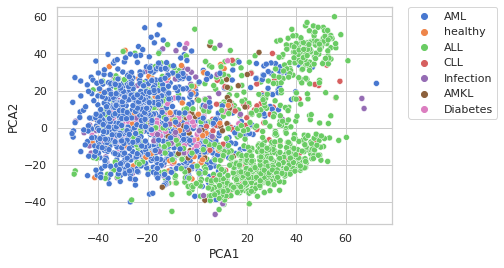

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = pca.fit(df).transform(df)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
y_lan = le.transform(target)

pca_df = pd.DataFrame(columns = ["x", "y", "name", "label"])
pca_df["PCA1"] = X[:, 0]
pca_df["PCA2"] = X[:, 1]
pca_df["Disease"] = target
pca_df["label"] = y_lan

sns.set(style="whitegrid", palette="muted")
#sns.set_theme(style="whitegrid")

ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Disease",  data=pca_df)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("GSE122505_Leukemia_PCA.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_PCA.png")
#pca_df.to_csv("GSE122505_Leukemia_PCA.csv")

## DBSCAN


In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan.fit(df)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

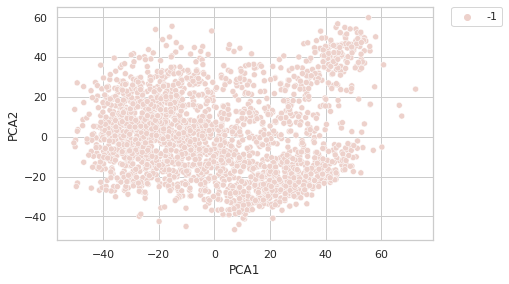

In [ ]:
pca_df["dbscan_labels"] = dbscan.labels_
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="dbscan_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#save it
#plt.savefig("GSE122505_Leukemia_kmeans.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_kmeans.png")
#pca_df.to_csv("GSE122505_Leukemia_kmeans.csv")

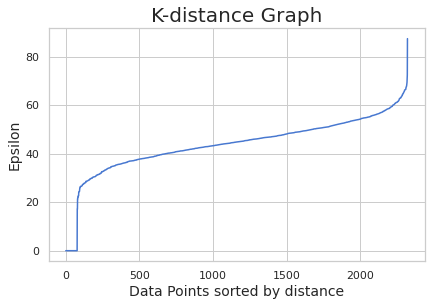

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df)
distances, indices = nbrs.kneighbors(df)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:
#install kneed on google colab
!pip install kneed
#import required libraries
from kneed import KneeLocator
kl = KneeLocator(distances[1000:len(distances)], range(1000, len(distances)), curve="convex", direction="decreasing")
kl.elbow

43.28211693010413

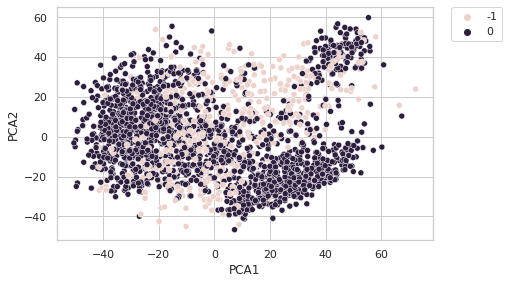

In [ ]:
dbscan=DBSCAN(eps=60,min_samples=50)
dbscan.fit(df)
pca_df["dbscan_labels"] = dbscan.labels_
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="dbscan_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


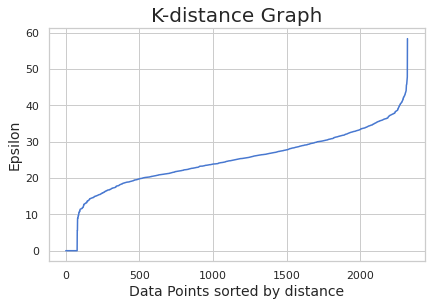

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
#plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

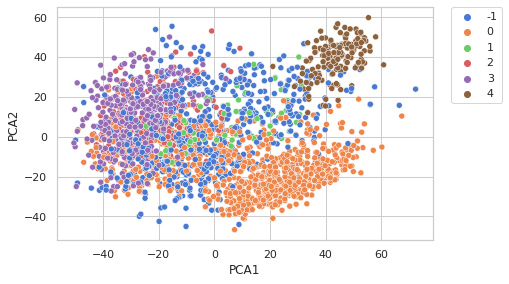

In [ ]:
dbscan=DBSCAN(eps=40,min_samples=30)
dbscan.fit(X)
pca_df["dbscan_labels"] = dbscan.labels_
pca_df['dbscan_labels'] = pca_df.dbscan_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="dbscan_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


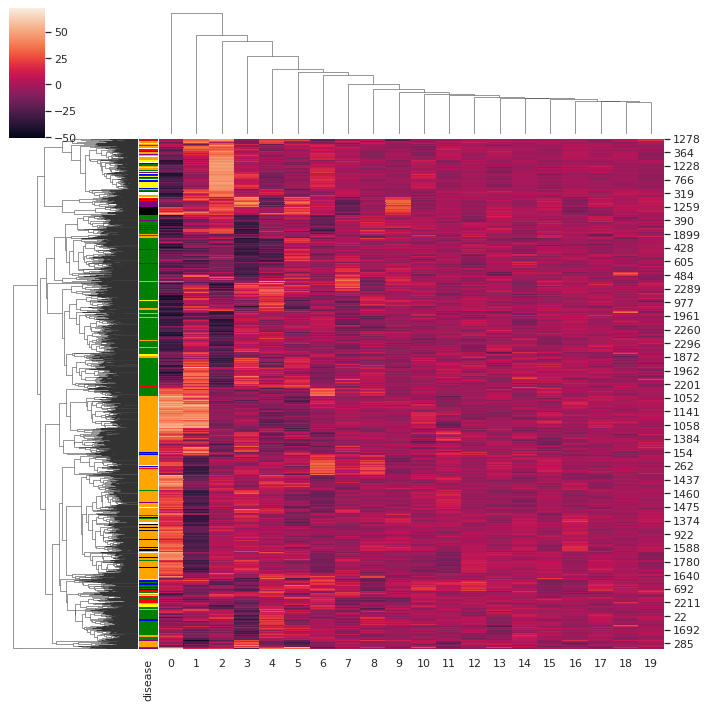

In [ ]:
import seaborn as sns; sns.set_theme(color_codes=True)
#pca = PCA(n_components=20)
#Y = pca.fit(df).transform(df)
#Y = pd.DataFrame(Y)
k = ["green", "red", "orange", "black", "purple", "blue", "yellow"]
lut = dict(zip(target.unique(), k))
row_colors = target.map(lut)

g = sns.clustermap(Y, row_colors=row_colors)

## Gaussian Mixture Models

In [ ]:
#we fit the data
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

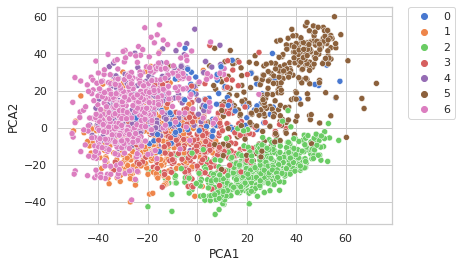

In [ ]:
#we plot the results
pca_df["GMM_labels"] = gmm.predict(X)
pca_df['GMM_labels'] = pca_df.GMM_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="GMM_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

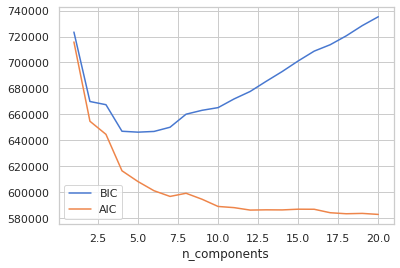

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
new_data = gmm.sample(1000)

In [ ]:
#since our data are returned in a tuple
gmm_components = new_data[:][0]
gmm_new_labels = new_data[:][1]

In [ ]:
gmm_components.shape

(1000, 50)

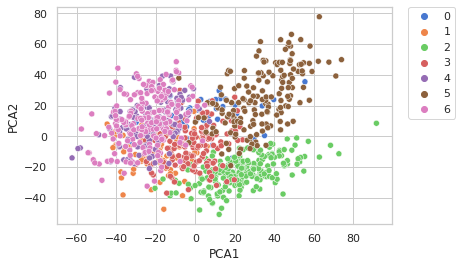

In [ ]:
new_df = pd.DataFrame(columns = ["x", "y", "gmm_new_labels"])
new_df["PCA1"] = gmm_components[:, 0]
new_df["PCA2"] = gmm_components[:, 1]
new_df["gmm_new_labels"] = gmm_new_labels

new_df['gmm_new_labels'] = new_df.gmm_new_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="gmm_new_labels",  data=new_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)